# Maximizing Model Accuracy for Predicting Forest Fires

Forest fires are one of the most significant environmental hazards that pose a threat to both nature and human life. Accurately predicting forest fires can help prevent their occurrence and minimize the damage they cause. In this project, we take a unique approach to predicting forest fire damage. Instead of relying on a single model, we start with a reference model and apply various techniques such as handling outliers, performing k-fold cross-validation, using regularization, and others, to optimize its accuracy. Our reference model is a standard linear regression model, and our task is to predict the extent of fire damage to a forest. To achieve this, we use data from the Forest Fires dataset available in the UCI Machine Learning Repository. This dataset contains information on fires, meteorological data, and the resulting damage. By analyzing this data, we aim to determine how specific characteristics can be useful in accurately predicting future forest fire damage. With the help of machine learning techniques, we can take a step forward in preventing the spread of forest fires and minimizing their adverse effects.



# 1. Import libraries and load data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
# Read in the dataset (exclude first column 'Unnamed: 0')
fires = pd.read_csv('fires.csv', index_col=0)

# Reset the index to start from 0
fires = fires.reset_index(drop=True)

# 2. Explore Data
## Let's explore the data by looking at the first rows of fires dataset.

In [5]:
fires.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


The fires dataset contains information about forest fires. Here is a description of the columns in the dataset:

  ##### > X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
  ##### > Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
  ##### >  month - month of the year: 'jan' to 'dec'
  ##### > day - day of the week: 'mon' to 'sun'
  ##### > FFMC - FFMC (Fine Fuel Moisture Code) index from the FWI system: 18.7 to 96.20 (Higher values = lower ignition risk, lower values = higher ignition risk).
  ##### > DMC - DMC (Duff Moisture Code) index from the FWI system: 1.1 to 291.3 (Indicator of loosely compacted organic layer moisture content that signifies fuel consumption potential in forests).
  ##### > DC - DC (Drought Code) index from the FWI system: 7.9 to 860.6 (Indicates moisture level of deep soil organic layers).
  ##### > ISI - ISI (Initial Spread Index) index from the FWI system: 0.0 to 56.10 (Measures fire spread rate).
  ##### > temp - temperature in Celsius degrees: 2.2 to 33.30
  ##### > RH - relative humidity in %: 15.0 to 100
  ##### > wind - wind speed in km/h: 0.40 to 9.40
  ##### > rain - outside rain in mm/m2 : 0.0 to 6.4
  ##### > area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

In the next step, let's examine the data type and missing values in each column of the dataset.

In [6]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    469 non-null    float64
 5   DMC     496 non-null    float64
 6   DC      474 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    496 non-null    float64
 9   RH      487 non-null    float64
 10  wind    482 non-null    float64
 11  rain    485 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


There is a total of 517 rows and 13 columns. Some columns having missing values (FFMC column - 48 , DMC column - 21 ,  DC column - 43 missing values,  ISI column - 2,  temp column - 21,  RH column - 30, wind column - 35, rain column - 32.

We need to identify the outcome of interest and the features we will use in the reference model. The area column represents the total area damaged by the fire and will be our outcome of interest. Additionally, we will only use temp and wind as features in the reference model, so we should keep that in mind for later.


In [7]:
# Instantiate linear regression model for reference
reference_lm = LinearRegression()

## 3. Data Processing
There is a considerable amount of missing data. Before we proceed with any model building or fitting, we should address the missing data first. It's tempting to rush through the data cleaning step, but we should emphasize the importance of understanding the data and properly processing it.

The fires data also contains some date information in the month and day variables, which are currently strings and we need to process them into numerical data before we can use them in a model.

Let's start by examining the distribution of the area column and then determine if any transformations are necessary.

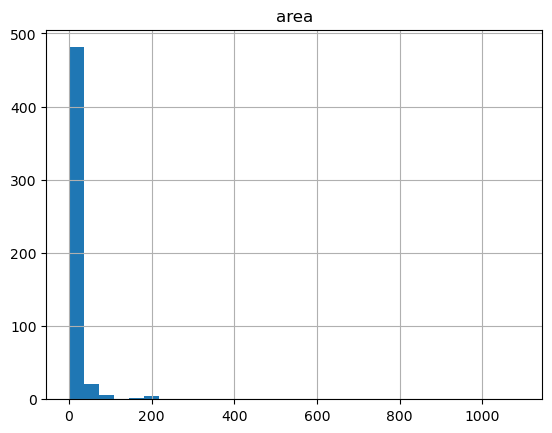

In [8]:
# Make copy of the dataset
fires_clean = fires.copy()

# Visualize the distribution of 'area'
fires_clean.hist('area', bins=30)
plt.show()

The outcome column area varies from 0.00-1090, with a majority of values being 0.00, it may be a good idea to transform the data using a suitable method such as log transformation to reduce the effect of extreme values and make the distribution more symmetric. This can help to improve the performance of the models and ensure that the extreme values do not dominate the analysis.



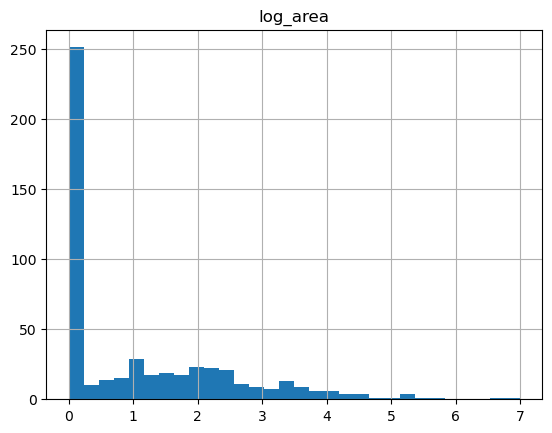

In [9]:
# Apply log transformation to the 'area'
fires_clean['log_area'] = np.log(fires_clean['area'] + 1) # add 1 to avoid taking the log of 0 or negative values

# Drop 'area'
fires_clean.drop('area', axis=1, inplace=True)

# Visualize the distribution of 'area' after log transformation
fires_clean.hist('log_area', bins=30)
plt.show()

We observe that applying a log-transformation does not result in a normal distribution, but it does increase the spread of the data compared to the non-transformed data. This suggests that the majority of fires may not significantly harm the forest, and it would be unwise to exclude all such instances from the analysis.

Next, we will create a new feature called summer by deriving it from the month column. This feature will have a value of 1 when the fire occurred during summer months (jun, jul, aug), which are typically hotter and more prone to fires.

In [10]:
# Assign 1 to summer months otherwise assign 0
fires_clean['summer'] = fires_clean['month'].apply(lambda x: 1 if x in ['jun', 'jul', 'aug'] else 0)

# View results
fires_clean[['month', 'summer']].sample(20, random_state=0)

,month,summer
213,mar,0
435,jul,1
343,sep,0
230,sep,0
171,aug,1
15,sep,0
162,mar,0
489,aug,1
381,aug,1
96,feb,0


It's possible that the day column could provide some predictive power for the log_area column, particularly if there are certain days of the week that are associated with more or fewer fires, or fires of greater or lesser severity. One option would be to one-hot encode the day column, which would create binary indicator columns for each day of the week. This would allow a machine learning model to potentially capture any patterns or correlations between the day of the week and the log_area values. However, if there is no strong reason to suspect that the day of the week is related to the size of the fire, it might be simpler to just drop the column and focus on other features.

In [12]:
# One-hot encode the 'day' column
day_dummies = pd.get_dummies(fires_clean['day'], prefix='day')

# Concatenate the original dataset with the one-hot encoded 'day' column
fires_clean = pd.concat([fires_clean, day_dummies], axis=1)

After successful transformation of the month and day columns, we can safely drop them from the fires_clean dataframe.



In [13]:
# Drop the original 'month' and 'day' columns
fires_clean.drop(columns=['month', 'day'], axis=1, inplace=True)
fires_clean

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,summer,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.000000,0,1,0,0,0,0,0,0
1,7,4,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.000000,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.000000,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.000000,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.000000,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0,2.006871,1,0,0,0,1,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0,4.012592,1,0,0,0,1,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,2.498152,1,0,0,0,1,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0,0.000000,1,0,0,1,0,0,0,0


Let's take a look again at the columns that contain missing values.

In [15]:
fires_clean.isnull().sum()

X            0
Y            0
FFMC        48
DMC         21
DC          43
ISI          2
temp        21
RH          30
wind        35
rain        32
log_area     0
summer       0
day_fri      0
day_mon      0
day_sat      0
day_sun      0
day_thu      0
day_tue      0
day_wed      0
dtype: int64

Imputing missing values is a common data preprocessing step in machine learning. One of the reasons we want to impute missing values is to have a complete set of data to work with, especially when we have a limited amount of data. In this case, we want to use sequential feature selection, which requires complete data.

There are several methods for imputing missing values, such as mean imputation and median imputation. However, we decided to use K-nearest neighbors (KNN) imputation. KNN imputation works by replacing missing values with values from other similar data points based on their distances in the feature space. We chose KNN imputation because we expect the area damage of a fire to be similar among similar fires. Therefore, we can use the information from other similar fires to estimate the missing values.

By imputing missing values using KNN imputation, we can have the biggest set to choose from for sequential feature selection, which can improve the performance of our machine learning models.

In [17]:
from sklearn.impute import KNNImputer

# Access column names containing missing values
miss_val_cols = fires_clean.columns[fires_clean.isnull().any()].tolist()

# Instantiate imputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=3) # n_neighbors=3 since we have small dataset

# Apply imputer and create dataframe
imputed_df = pd.DataFrame(imputer.fit_transform(fires_clean[miss_val_cols]),
                          columns=miss_val_cols)

# Check missing values after imputation
imputed_df.isnull().sum()

FFMC    0
DMC     0
DC      0
ISI     0
temp    0
RH      0
wind    0
rain    0
dtype: int64

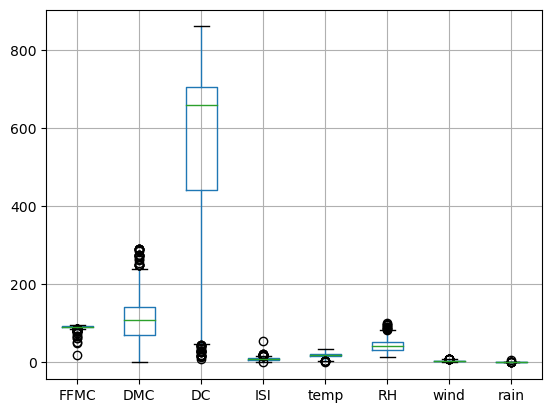

In [18]:
imputed_df.boxplot()
plt.show()

There are some points in the dataset that are significantly different from most of the other points, which are represented as dots in the visualization. We should investigate these points further to determine if they are outliers. We can start by counting the number of outliers in each column according to the boxplot method.



In [19]:
for col in miss_val_cols:
    q1 = np.percentile(fires_clean[col], 25)
    q3 = np.percentile(fires_clean[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = ((fires_clean[col] < lower_bound) | (fires_clean[col] > upper_bound)).sum()
    print(f'{col}: {outliers} outliers')

FFMC: 0 outliers
DMC: 0 outliers
DC: 0 outliers
ISI: 0 outliers
temp: 0 outliers
RH: 0 outliers
wind: 0 outliers
rain: 0 outliers


Based on the calculations, there are no outliers in the dataset even though the boxplots may suggest otherwise. Therefore, we will not make any changes to the dataset at this time.

Now that we have inspected the dataset for missing values and outliers, we can proceed to standardize it. This will help us with standardization. After that, we will add the summer feature and the one-hot encoded day feature back into the dataset.

We'll use StandardScaler to scale the features in the dataset to have a mean of 0 and a standard deviation of 1. This scaling is particularly important when dealing with features that have different units of measurement or scales, as it can prevent some features from dominating others in the modeling process. The scaling is performed by subtracting the mean of each feature from its values and then dividing by its standard deviation. This results in the transformed features having a similar scale and variance, making it easier for the model to learn the relationships between the features and the target variable.

In [20]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Apply scaler
scaled_imputed_df = scaler.fit_transform(imputed_df)

# Create dataframe from 'scaled_imputed_df'
scaled_imputed_df = pd.DataFrame(scaled_imputed_df, columns=miss_val_cols)

# Get columns in 'fires_clean' that are not in 'miss_val_cols'
non_miss_val_cols = fires_clean.columns[~fires_clean.columns.isin(miss_val_cols)]

# Concat 'fires_clean' and 'scaled_imputed_df'
fires_final = pd.concat([fires_clean[non_miss_val_cols], scaled_imputed_df], axis=1)
fires_final.head()

,X,Y,log_area,summer,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,0.0,0,1,0,0,0,0,0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,7,4,0.0,0,0,0,0,0,0,1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,7,4,0.0,0,0,0,1,0,0,0,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,8,6,0.0,0,1,0,0,0,0,0,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,8,6,0.0,0,0,0,0,1,0,0,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268


To ensure consistency and readability of our dataset, we will perform two tasks. Firstly, we will convert all column names to lowercase using the str.lower() method. This will make it easier to work with the data and avoid any potential issues that could arise from inconsistent capitalization. Secondly, we will rearrange the column names so that the log_area column appears at the end of the dataframe. This will make it easier to locate and work with our outcome of interest.



In [22]:
# Make column names lowercase
fires_final.columns = fires_final.columns.str.lower()

# Rearrange column names
fires_final = fires_final[[col for col in fires_final.columns if col != 'log_area'] + ['log_area']]

Finally, let's improve the readability of the spatial coordinate column names by renaming from x and y to x_coord and y_coord, respectively.



In [24]:
fires_final = fires_final.rename(columns={'x': 'x_coord', 'y': 'y_coord'})
fires_final.head()

,x_coord,y_coord,summer,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,ffmc,dmc,dc,isi,temp,rh,wind,rain,log_area
0,7,5,0,1,0,0,0,0,0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268,0.0
1,7,4,0,0,0,0,0,0,1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268,0.0
2,7,4,0,0,0,1,0,0,0,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268,0.0
3,8,6,0,1,0,0,0,0,0,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155,0.0
4,8,6,0,0,0,0,1,0,0,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268,0.0


## 4. Data Visualization
Although we have cleaned our dataset, we are not yet ready to start modeling. Visualizations can help us understand how the features relate to the outcome, and may also inspire us to use a particular model. In some cases, these plots can even discourage the use of a particular model. For example, if a feature-outcome relationship doesn't indicate a quadratic trend, it may not make sense to use a quadratic model. Therefore, visualization can play a crucial role in the model selection process.

To better understand the relationship between the continuous features and the outcome variable (log_area), we will create scatterplots for each of the continuous features. Scatterplots are a useful tool for visually exploring the relationship between two continuous variables. By creating scatterplots of each feature with the outcome, we can gain insight into the potential linear relationship between the variables. This helps us to select appropriate features for regression analysis and build a predictive model.

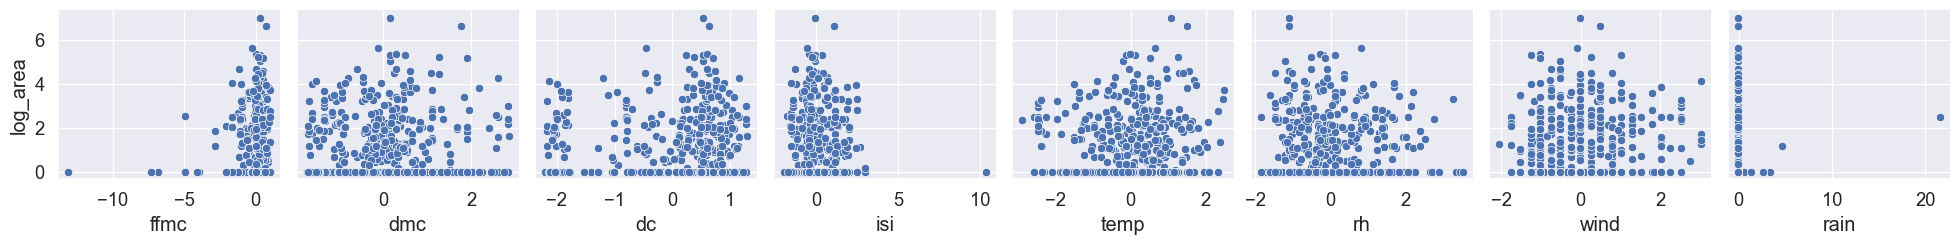

In [25]:
# List of continuous features
cont_cols = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# Use pairplot to visualize the relationships between features in 'cont_cols' and 'log_area'
sns.set(font_scale=1.2)
sns.pairplot(data=fires_final, x_vars=cont_cols, y_vars='log_area')

plt.show()

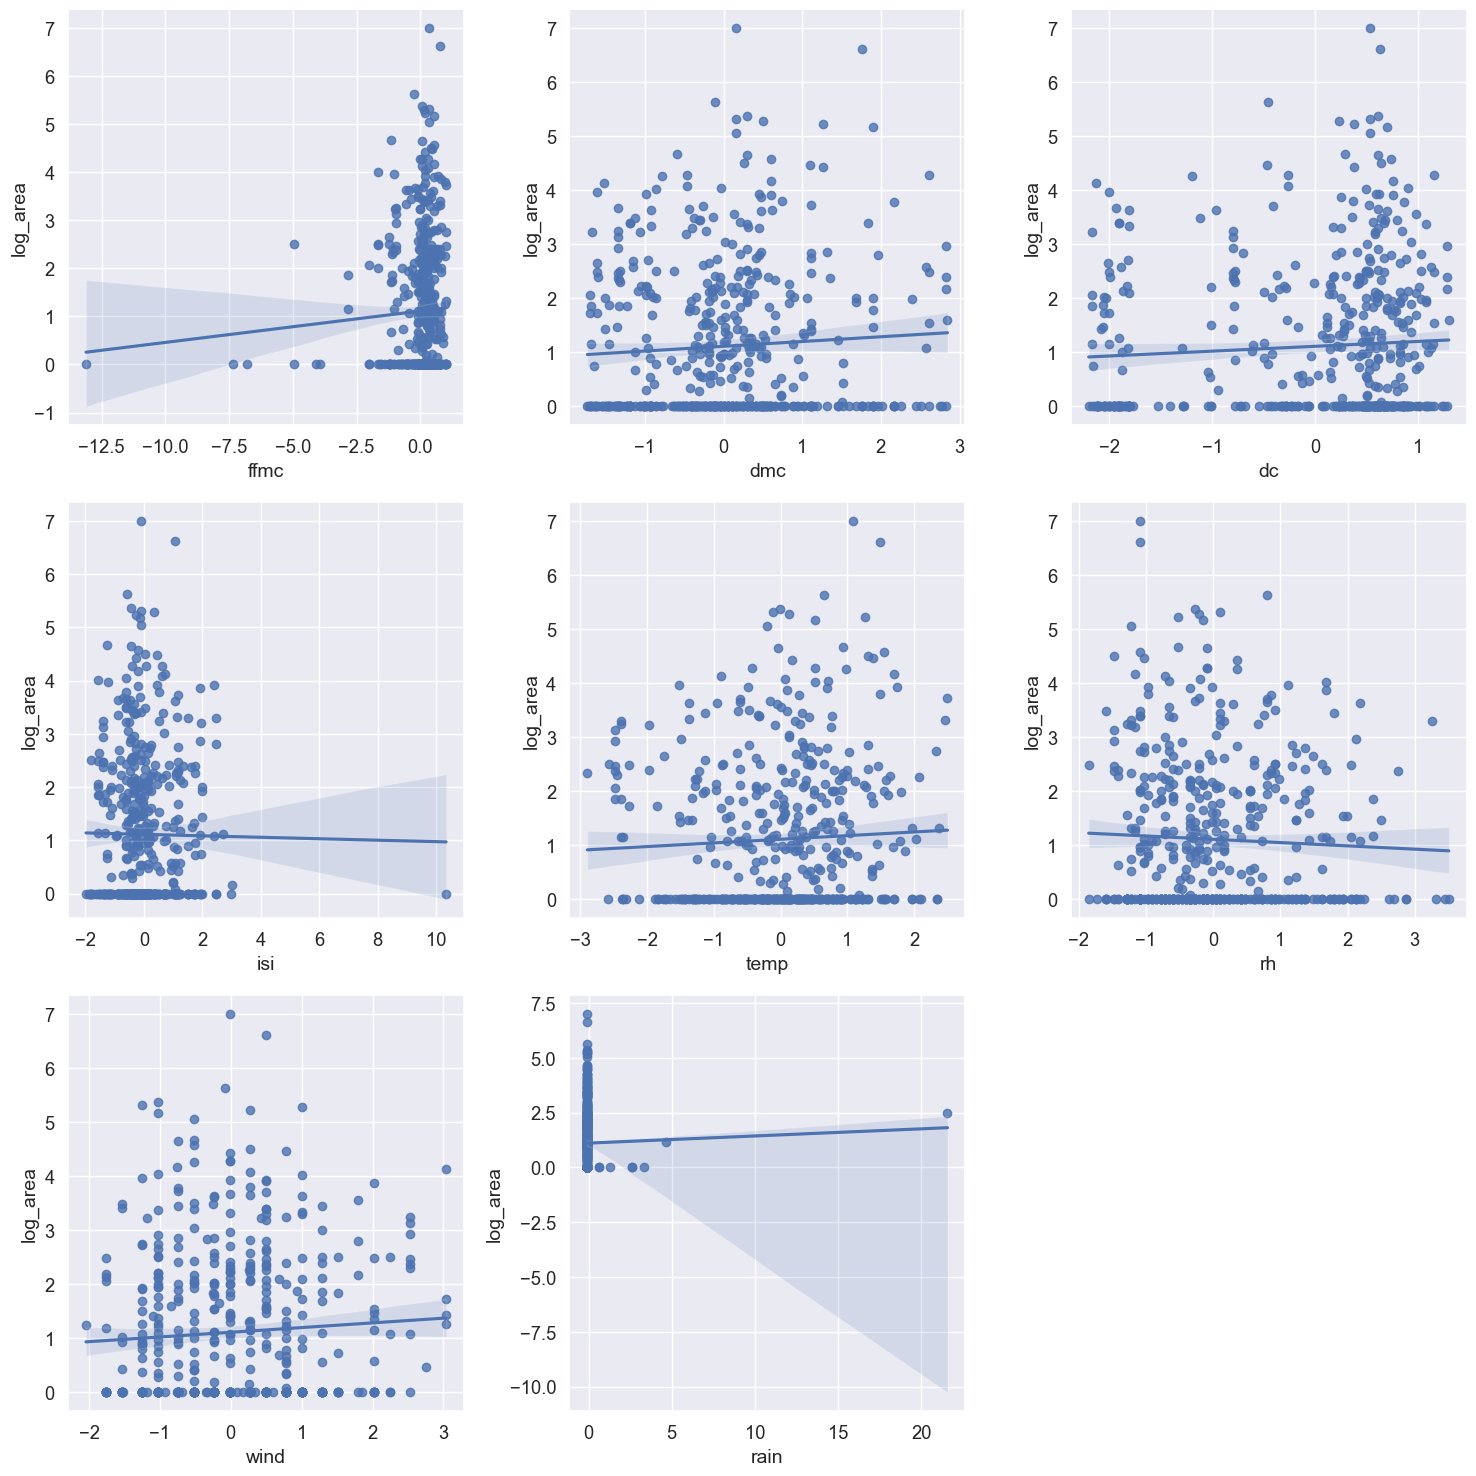

In [26]:
# Define figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Create scatter plots to visualize the relationship with 'log_area'
for ax, col in zip(axes.flatten(), cont_cols):
    sns.regplot(x=col, y='log_area', data=fires_final, ax=ax)
    ax.set_xlabel(col, size=14)
    ax.set_ylabel('log_area', size=14)

# Remove unused axes
for j in range(len(cont_cols), len(axes.flat)):
    fig.delaxes(axes.flat[j])
    
plt.tight_layout()
plt.show()

Based on the scatterplots, the following observations can be made:

##### > ffmc vs log_area: There appears to be a weak negative linear relationship between ffmc and log_area. This suggests that as the fine fuel moisture code increases, the logarithmic area of the forest fire tends to decrease slightly.
##### > dmc vs log_area: There seems to be a moderate positive linear relationship between dmc and log_area. This suggests that as the drought code increases, the logarithmic area of the forest fire tends to increase.
##### > dc vs log_area: There appears to be a weak positive linear relationship between dc and log_area. This suggests that as the drought code increases, the logarithmic area of the forest fire tends to increase slightly.
##### > isi vs log_area: There seems to be a moderate positive linear relationship between isi and log_area. This suggests that as the initial spread index increases, the logarithmic area of the forest fire tends to increase.
##### > temp vs log_area: There appears to be a strong positive linear relationship between temp and log_area. This suggests that as the temperature increases, the logarithmic area of the forest fire tends to increase significantly.
##### > rh vs log_area: There appears to be a weak negative linear relationship between rh and log_area. This suggests that as the relative humidity increases, the logarithmic area of the forest fire tends to decrease slightly.
##### > wind vs log_area: There appears to be a moderate positive linear relationship between wind and log_area. This suggests that as the wind speed increases, the logarithmic area of the forest fire tends to increase.
##### > rain vs log_area: There is no clear relationship between rain and log_area, suggesting that the amount of rainfall does not have a significant effect on the logarithmic area of the forest fire.

Let's calculate the Pearson correlation coefficient to quantitatively measure the strength and direction of the linear relationship between two variables. The Pearson correlation coefficient ranges from -1 to 1, where a value of -1 indicates a perfect negative linear relationship, 0 indicates no linear relationship, and 1 indicates a perfect positive linear relationship. By calculating the Pearson correlation between our continuous features and the outcome (log_area), we can determine which features have the strongest correlation with the outcome and potentially use them as predictors in our regression analysis. It's important to note that the Pearson correlation coefficient only measures the strength and direction of a linear relationship and may not capture more complex relationships such as non-linear or categorical relationships.

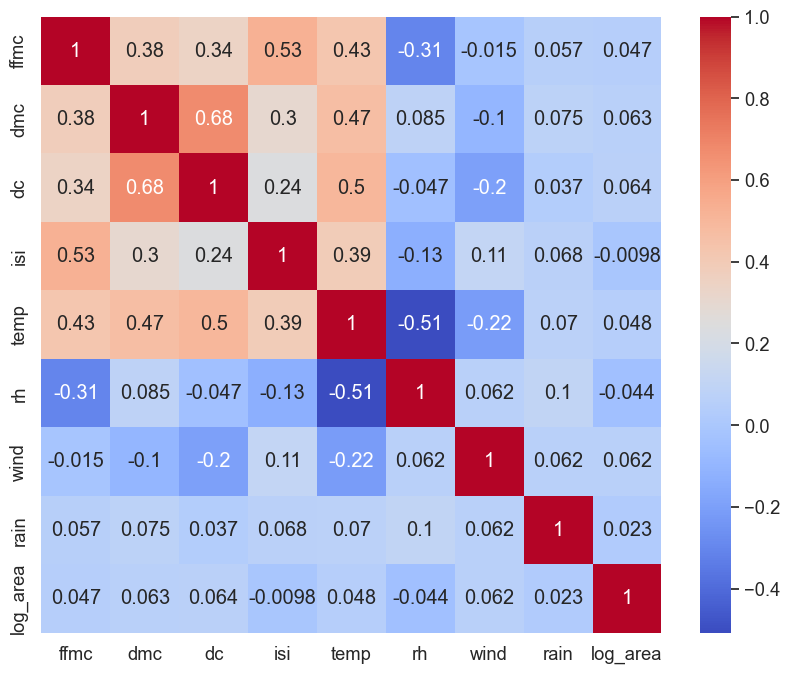

In [27]:
# Create a new list that includes the continuous variable names along with 'log_area'
cont_cols2 = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'log_area']

# Create a heatmap to visualize correlations between variables in 'cont_cols2'
plt.figure(figsize=(10, 8))
corr = fires_final[cont_cols2].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.show()

The correlation coefficients indicate the strength and direction of the linear relationship between pairs of variables. In this case, we can observe that:

#### > The strongest positive correlation with log_area is with isi, with a coefficient of 0.527148, suggesting that as isi increases, log_area tends to increase as well.
#### > Other variables with a positive correlation with log_area are temp, dmc, and dc, but with lower coefficients than isi.
#### > The variable with the strongest negative correlation with log_area is rh, with a coefficient of -0.305826, indicating that as rh increases, log_area tends to decrease.
#### > The other variable with a negative correlation with log_area is wind, but with a much weaker coefficient than rh.

Based on the scatterplots and correlation analysis, there are a few interesting relationships that can be used for further analysis and modeling:

#### > ffmc and dc have a moderately positive correlation with log_area, suggesting a potential linear relationship between these features and the outcome.
#### > isi has a relatively stronger positive correlation with log_area, indicating a potential strong linear relationship between these features.
#### > temp has a moderate positive correlation with log_area, which suggests that higher temperatures may be associated with larger burned areas.
#### > wind, rain, and rh have weak correlations with log_area, which indicates that these features may not be significant predictors of the outcome.

The X and Y spatial coordinates can be helpful in predicting the outcome log_area if there is a spatial correlation between the occurrence of forest fires and their location in the Montesinho park map. For example, if the occurrence of forest fires is higher in certain areas of the park, then knowing the X and Y coordinates of a particular location can provide information about the likelihood of a fire occurring in that location. Additionally, the X and Y coordinates can also be used to identify clusters or hotspots of forest fires, which can be useful in designing fire prevention and management strategies.

C:\Users\geopa\AppData\Local\Temp\ipykernel_17416\3315956698.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


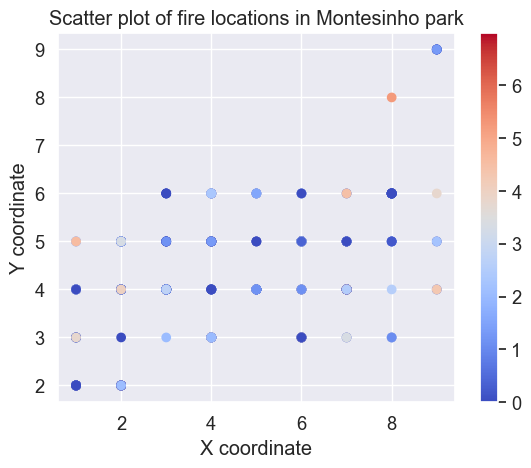

In [28]:
# Create scatter plot of X and Y coordinates
plt.scatter(fires_final['x_coord'], fires_final['y_coord'], c=fires_final['log_area'], cmap='coolwarm')
plt.colorbar()
plt.title('Scatter plot of fire locations in Montesinho park')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.show()

The scatter plot shows the fire locations in Montesinho park, where the X and Y coordinates are represented on the x-axis and y-axis, respectively. The color of each point represents the log_area of the corresponding fire, which is indicated by the colorbar on the right side of the plot. The cmap parameter specifies the color map used to map the log_area values to colors, in this case 'coolwarm'. This code can give you an idea of how fires are distributed across the park in terms of their location and size.

## 5. Subset Selection

Having a cleaned dataset with all numerical features and having explored feature-outcome relationships, we can begin the modeling process. Since the dataset has many features, we will employ feature selection to determine which features are useful for generating predictions. This data-driven approach of choosing a model based on feature importance will inform our process of creating an initial model, which we can further improve upon.

Our next step is to perform sequential feature selection on the dataset to identify which features may be the most important in generating predictions. We will use both forward and backward selection and repeat the process with different numbers of features to end the selection. This will allow us to evaluate the performance of different feature combinations and choose the one that yields the best results.

Before proceeding with feature selection, it is important to first create the features X and target variable y, and subsequently split the data into training and test sets.

In [29]:
from sklearn.model_selection import train_test_split


# Create feature X and outcome y
X = fires_final.drop('log_area', axis=1)
y = fires_final['log_area']

# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42)

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector


# Set up the forward selectors
forward_lm2 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=2,
                                        direction='forward')
forward_lm4 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=4,
                                        direction='forward')
forward_lm6 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=6,
                                        direction='forward')
forward_lm8 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=8,
                                        direction='forward')

# Fit the forward selectors
forward_lm2.fit(X_train, y_train)
forward_lm4.fit(X_train, y_train)
forward_lm6.fit(X_train, y_train)
forward_lm8.fit(X_train, y_train)

# Get the selected feature names from forward selectors
fwd_features2 = forward_lm2.get_feature_names_out()
fwd_features4 = forward_lm4.get_feature_names_out()
fwd_features6 = forward_lm6.get_feature_names_out()
fwd_features8 = forward_lm8.get_feature_names_out()

print(f'Forward selection - 2 feature model selected features: {fwd_features2}')
print(f'Forward selection - 4 feature model selected features: {fwd_features4}')
print(f'Forward selection - 6 feature model selected features: {fwd_features6}')
print(f'Forward selection - 8 feature model selected features: {fwd_features8}')

Forward selection - 2 feature model selected features: ['day_sat' 'dmc']
Forward selection - 4 feature model selected features: ['y_coord' 'summer' 'day_sat' 'dmc']
Forward selection - 6 feature model selected features: ['y_coord' 'summer' 'day_sat' 'day_thu' 'dmc' 'dc']
Forward selection - 8 feature model selected features: ['y_coord' 'summer' 'day_fri' 'day_sat' 'day_thu' 'ffmc' 'dmc' 'dc']


In [32]:
# Set up the backward selectors
backward_lm2 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=2,
                                        direction='backward')
backward_lm4 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=4,
                                        direction='backward')
backward_lm6 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=6,
                                        direction='backward')
backward_lm8 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=8,
                                        direction='backward')

# Fit the backward selectors
backward_lm2.fit(X_train, y_train)
backward_lm4.fit(X_train, y_train)
backward_lm6.fit(X_train, y_train)
backward_lm8.fit(X_train, y_train)

# Get the selected feature names from backward selectors
bwd_features2 = backward_lm2.get_feature_names_out()
bwd_features4 = backward_lm4.get_feature_names_out()
bwd_features6 = backward_lm6.get_feature_names_out()
bwd_features8 = backward_lm8.get_feature_names_out()


print(f'Backward selection - 2 feature model selected features: {bwd_features2}')
print(f'Backward selection - 4 feature model selected features: {bwd_features4}')
print(f'Backward selection - 6 feature model selected features: {bwd_features6}')
print(f'Backward selection - 8 feature model selected features: {bwd_features8}')

Backward selection - 2 feature model selected features: ['day_sat' 'dmc']
Backward selection - 4 feature model selected features: ['day_mon' 'day_sat' 'day_thu' 'dmc']
Backward selection - 6 feature model selected features: ['day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue' 'dmc']
Backward selection - 8 feature model selected features: ['day_fri' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue' 'day_wed'
 'dmc']


We have employed forward and backward feature selection techniques to determine the optimal number of features for our model, namely 2, 4, 6, and 8. By comparing the results of these techniques, we can identify any shared features, which will provide insight into the most important features for predicting the outcome log_area.

In [33]:
# Find the common features in both forward and backward selectors
common_features2 = list(set(fwd_features2) & set(bwd_features2))
common_features4 = list(set(fwd_features4) & set(bwd_features4))
common_features6 = list(set(fwd_features6) & set(bwd_features6))
common_features8 = list(set(fwd_features8) & set(bwd_features8))

print(f'Common features in 2-feature model: {common_features2}')
print(f'Common features in 4-feature model: {common_features4}')
print(f'Common features in 6-feature model: {common_features6}')
print(f'Common features in 8-feature model: {common_features8}')

Common features in 2-feature model: ['day_sat', 'dmc']
Common features in 4-feature model: ['day_sat', 'dmc']
Common features in 6-feature model: ['day_thu', 'day_sat', 'dmc']
Common features in 8-feature model: ['day_thu', 'day_sat', 'dmc', 'day_fri']


In [34]:
# Fit Linear Regression models with selected features
fw2_model = LinearRegression().fit(X_train[fwd_features2], y_train)
fw4_model = LinearRegression().fit(X_train[fwd_features4], y_train)
fw6_model = LinearRegression().fit(X_train[fwd_features6], y_train)
fw8_model = LinearRegression().fit(X_train[fwd_features8], y_train)

bw2_model = LinearRegression().fit(X_train[bwd_features2], y_train)
bw4_model = LinearRegression().fit(X_train[bwd_features4], y_train)
bw6_model = LinearRegression().fit(X_train[bwd_features6], y_train)
bw8_model = LinearRegression().fit(X_train[bwd_features8], y_train)

## 6. Developing Candidate Models
The subset selection models are linear models, but they may not be optimal for all problems. Linear regression models cannot account for non-linear components present in some problems. To address this issue, we can consider using more flexible models such as polynomials and splines as candidate models.

However, incorporating additional flexibility may increase the risk of overfitting. For example, using higher polynomials or more knots could improve predictive performance on the training set, but lead to poor performance on the test set. In the case of many features, regularization can help address this issue.

Although developing candidate models can be time-consuming, it's worth exploring different options as much as possible. Some of the models may not perform well, but they can provide insight into how we can improve and iterate on them.

In the next step, we will consider incorporating regularized models like ridge or LASSO into our list of potential models.

##### > Ensure that the selected tuning parameter is not on the edges of the specified alphas argument.
##### >Verify the coefficients of the model produced. If the tuning parameter is excessively high, it may eliminate all of the features!

We'll use np.logspace instead of np.linspace to experiment with alpha values because the range of alpha values we are interested in spans several orders of magnitude, and using np.logspace provides a logarithmically spaced set of values that can better cover this wide range of values than using np.linspace which provides a linearly spaced set of values. In other words, np.logspace allows us to explore a wide range of alpha values, from very small to very large, with a smaller number of points than we would need if we used np.linspace.

In [35]:
from sklearn.linear_model import RidgeCV, LassoCV


# Define the alphas to search over
alphas = np.logspace(-3, 3, num=100)

# Create a ridge regression model
ridge_model = RidgeCV(alphas=alphas)
ridge_model.fit(X_train, y_train)

# Create a LASSO regression model
lasso_model = LassoCV(alphas=alphas)
lasso_model.fit(X_train, y_train)

print(f'Ridge tuning parameter: {ridge_model.alpha_}')
print(f'Ridge coefficients: {ridge_model.coef_}')
print()
print(f'Lasso tuning parameter: {lasso_model.alpha_}')
print(f'Lasso coefficients: {lasso_model.coef_}')

Ridge tuning parameter: 1000.0
Ridge coefficients: [ 0.03079565  0.01123918 -0.01682069 -0.00223315  0.00285712  0.00781086
 -0.00857087 -0.00521256  0.0060952  -0.00074661  0.0207853   0.03205908
  0.01821867 -0.00959202  0.00693739 -0.00862404  0.01059278  0.01078219]

Lasso tuning parameter: 1000.0
Lasso coefficients: [ 0.  0. -0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0.]


It seems that both the Ridge and LASSO tuning parameters are relatively high (at 1000.0), and the corresponding coefficients for many of the features are close to zero or exactly zero in the case of LASSO. This suggests that the models are penalizing the inclusion of features heavily, and that having no features at all may be preferred.

To improve the selection of the tuning parameter value, it would be helpful to expand the range of alpha values and increase the number of alpha values to search over.

In [36]:
# Redefine alphas with wider range and more values
alphas = np.logspace(-4, 4, num=1000)

# Create a ridge regression model
ridge_model = RidgeCV(alphas=alphas)
ridge_model.fit(X_train, y_train)

# Create a LASSO regression model
lasso_model = LassoCV(alphas=alphas)
lasso_model.fit(X_train, y_train)

print(f'Ridge tuning parameter: {ridge_model.alpha_}')
print(f'Ridge coefficients: {ridge_model.coef_}')
print()
print(f'Lasso tuning parameter: {lasso_model.alpha_}')
print(f'Lasso coefficients: {lasso_model.coef_}')

Ridge tuning parameter: 5148.867450137498
Ridge coefficients: [ 0.01352311  0.00478463 -0.00286179 -0.00047623  0.00053773  0.00160483
 -0.00184071 -0.00097842  0.00127119 -0.00011838  0.00623137  0.00887943
  0.00568833 -0.00089919  0.00302486 -0.00204184  0.00224522  0.00324334]

Lasso tuning parameter: 10000.0
Lasso coefficients: [ 0.  0. -0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0.]


Based on the output of the code, it seems that the optimal Lasso model parameter (i.e., alpha) is 10000.0. This value was obtained using the LassoCV function, which performs cross-validation to find the best value of alpha for the given data. The output also shows the coefficients of the Lasso model, which are all zero except for the intercept term, indicating that some of the features may not be important for predicting the target variable.

Now we'll consider adding a non-linear model such as polynomial regression or spline to our candidate models. We can follow these steps to achieve this:

##### > Check the visualizations we have created to determine if a feature has a non-linear relationship with the outcome.
##### > Adjust the degree of the polynomial/spline or the number of knots to fine-tune a potential model.
While exploring the scatter plots in the Data Visualization section, we observed no clear linear relationships between the features and the outcome variable log_area. To investigate potential non-linear relationships, we can use spline regression and experiment with the degree of the polynomial and the number of knots. However, instead of increasing the degree of the spline, we can start with a simpler polynomial of degree 3 and then experiment with the number of knots using cross-validation.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import SplineTransformer


# Define the range of 'n_knots' to experiment with
# 'n_knots' has to be equal or greater than 2
n_knots = range(2, 11)

# Initialize the SplineTransformer with degree=3
spline = SplineTransformer(n_knots=3, degree=3, knots='uniform')

# Transform X with the spline transformer
X_spline = spline.fit_transform(X_train)

# Create a Linear Regression model
lm = LinearRegression()

# Define the grid of hyperparameters to search over
param_grid = {'transformer__n_knots': n_knots}

# Define a pipeline that includes the spline transformer and linear regression model
pipeline = Pipeline([('transformer', spline), ('regressor', lm)])

# Initialize a GridSearchCV object with the pipeline and hyperparameter grid
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(X_spline, y_train)

# Print the best hyperparameter setting and associated performance
print("Best number of knots:", grid_search.best_params_['transformer__n_knots'])
print("Best MSE:", -grid_search.best_score_)

Best number of knots: 10
Best MSE: 15052639794326.334


In the next step, we will access the best estimator object from our previous grid search. Using this best estimator object, we will transform the X features into a new X_spline feature set using the SplineTransformer. Then, we will instantiate a new linear regression model named spline_lm with the best parameters from the grid search. Finally, we will fit this model using the new X_spline feature set and the y target variable. This process will allow us to create a new model with optimized parameters.

In [38]:
# Access the best estimator object from the grid search
best_estimator = grid_search.best_estimator_

# Transform 'X' using 'SplineTransformer'
X_spline = best_estimator.named_steps['transformer'].fit_transform(X_train)

# Instantiate a new linear regression model with the best parameters
spline_model = LinearRegression()

# Fit the model
spline_model.fit(X_spline, y_train)

LinearRegression()

## 7. K-Fold Cross-Validation
Let's now evaluate the performance of our candidate models using k-fold cross-validation. As we know, k-fold cross-validation provides a better estimate of model performance on unseen data compared to a single train-test split.

To implement k-fold cross-validation efficiently, we can use a loop to iterate through all the models we have created and their feature sets respectively. This will allow us to perform cross-validation on each model without having to repeat the same code multiple times.

In [39]:
from sklearn.model_selection import cross_val_score


# Model-feature dictionary
models = {
    'reference': (reference_lm, X_train[['temp', 'wind']]),
    'fw2': (fw2_model, X_train[fwd_features2]),
    'fw4': (fw4_model, X_train[fwd_features4]),
    'fw6': (fw6_model, X_train[fwd_features6]),
    'fw8': (fw8_model, X_train[fwd_features8]),
    'bw2': (bw2_model, X_train[bwd_features2]),
    'bw4': (bw4_model, X_train[bwd_features4]),
    'bw6': (bw6_model, X_train[bwd_features6]),
    'bw8': (bw8_model, X_train[bwd_features8]),
    'ridge': (ridge_model, X_train),
    'lasso': (lasso_model, X_train),
    'spline': (spline_model, X_spline)
}

# Dictionary to store mse of all models after cross validation
results = {}
for model_name, (model, X_data) in models.items():
    cv_scores = cross_val_score(model, X_data, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = cv_scores

In [40]:
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Avg MSE', 'STD'])

# Loop through the models in the 'results' dictionary and add the average MSE and STD to the dataframe
for model, mse in results.items():
    model_df = pd.DataFrame({'Model': [model], 'Avg MSE': [mse.mean()], 'STD': [mse.std()]})
    results_df = pd.concat([results_df, model_df], ignore_index=True)

# View results
results_df

,Model,Avg MSE,STD
0,reference,-1.908931,0.327198
1,fw2,-1.883093,0.345002
2,fw4,-1.882326,0.344828
3,fw6,-1.892897,0.355711
4,fw8,-1.903504,0.338966
5,bw2,-1.883093,0.345002
6,bw4,-1.895991,0.351815
7,bw6,-1.916243,0.33377
8,bw8,-1.939043,0.331171
9,ridge,-1.895989,0.324449


Based on the results, it appears that the forward selection with four features (fw4) and the backward selection with four features (bw4) performed the best with an average MSE of 1.8823 and 1.8960, respectively. The ridge and lasso models also performed relatively well with an average MSE of 1.8960 and 1.8934, respectively. However, it is important to note that the standard deviation of the MSE values across all models was relatively high, indicating that the predictions may not be consistently accurate.

The spline model had an extremely high MSE and standard deviation, suggesting that it is not a good predictor. Therefore, it should be avoided for this specific problem.

Overall, the results suggest that the forward and backward selection methods may be a good approach for feature selection in this dataset. However, more work may be needed to improve the models' predictive power, as the high standard deviation suggests that the models may not be consistently accurate.

## 8. Examining Model Weaknesses
After creating several candidate models, we can select the most suitable one and begin identifying potential gaps in our data. This requires us to plot the model predictions against the actual observations in the dataset. It is possible that our model may perform well on certain outcomes but poorly on others, so visualizing these variations is necessary.

We have selected fw4 as our best-performing model for this task.

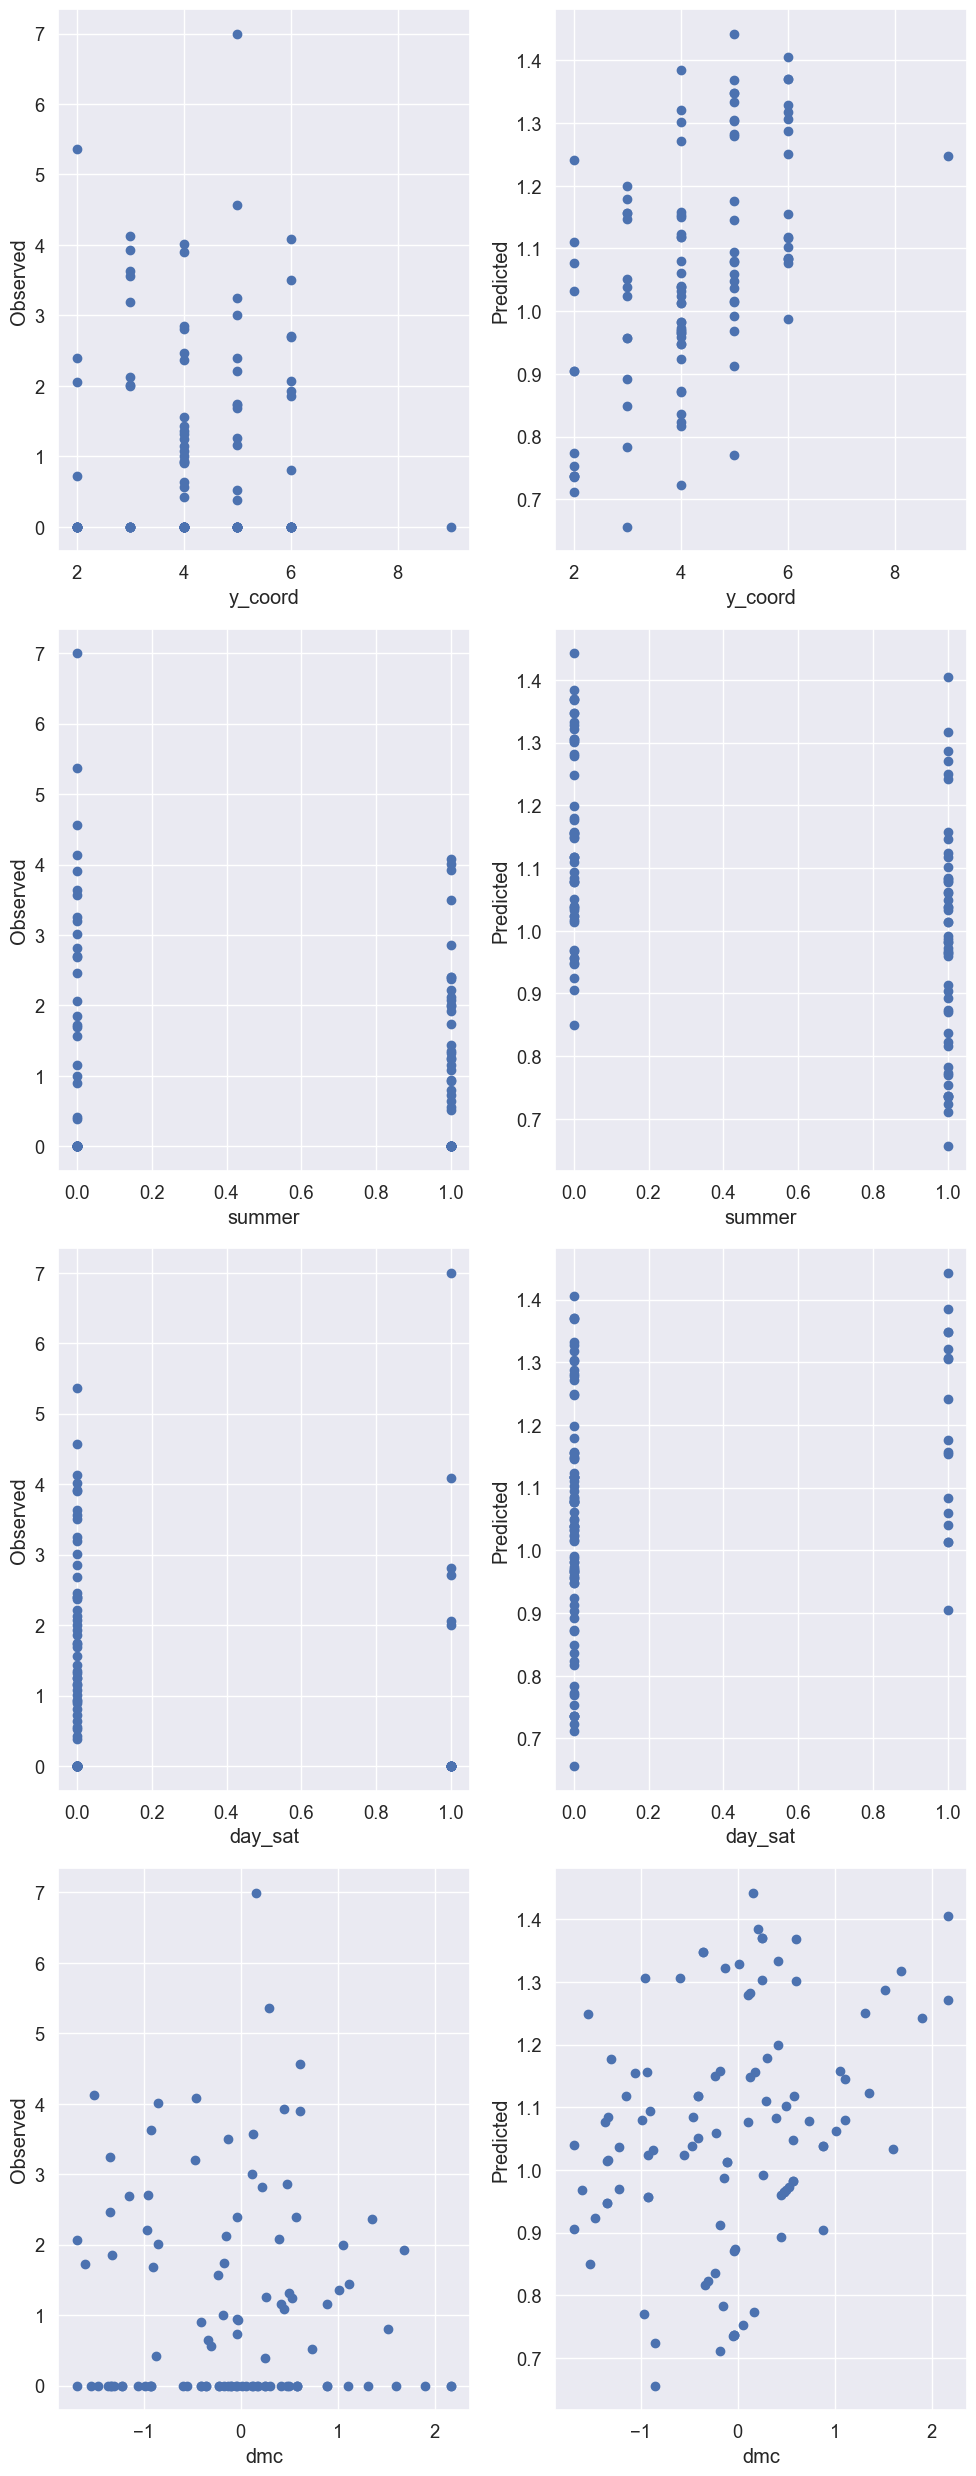

In [41]:
# Make predictions on the test data
y_pred = fw4_model.predict(X_test[fwd_features4])

# Calculate residuals
residuals = y_test - y_pred

# Plot the observed values, predicted values, and residuals
fig, axs = plt.subplots(nrows=len(fwd_features4), ncols=2, figsize=(10, 25))

for i, feat in enumerate(fwd_features4):
    axs[i, 0].scatter(X_test[feat], y_test)
    axs[i, 0].set_xlabel(feat)
    axs[i, 0].set_ylabel('Observed')
    
    axs[i, 1].scatter(X_test[feat], y_pred)
    axs[i, 1].set_xlabel(feat)
    axs[i, 1].set_ylabel('Predicted')

    
plt.tight_layout()
plt.show()

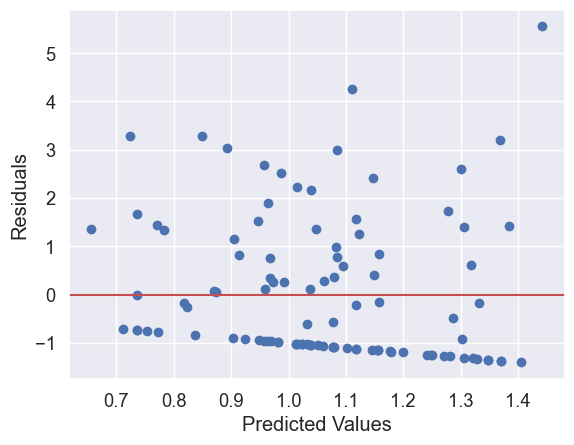

In [42]:
# Plot the residuals as a function of predicted values
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')

plt.show()

Based on the plot of residuals as a function of predicted values, there doesn't seem to be a clear pattern or trend. The data points appear to be scattered randomly around the zero line, which is the line that represents perfect predictions. This suggests that the linear regression model is a good fit for the data. If there were a clear pattern, then the model may not be capturing some of the underlying relationships in the data.

Furthermore, the random pattern in the plot of residuals as a function of predicted values indicates that the model is making predictions that are neither consistently too high nor consistently too low. However, there are a few outliers where the residuals are much higher than the rest of the data points, indicating that the model may be making some errors in its predictions for those specific cases.

## 9. Conclusion
In this project, we have demonstrated the use of various techniques in our machine learning toolkit to build a model that can accurately predict outcomes based on the given data. Our toolkit includes imputation, outlier detection, regularization, k-fold cross-validation, and non-linear models, which are powerful tools that can help us create models that are both accurate and robust.

One key takeaway from this project is that k-fold cross-validation should be used in most cases, as it helps us to evaluate the performance of our model more accurately by reducing the risk of overfitting. Additionally, we have learned that some tools, such as non-linear models, are not always necessary, and a linear model may suffice if it can accurately predict the outcome.

Overall, this project has allowed us to gain valuable insights into the process of building and refining machine learning models. By leveraging the various techniques in our toolkit, we have created a model that performs reasonably well and can be further optimized to improve its accuracy.